In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
import re

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
sns.set_palette('colorblind')

#### Encontra os ótimos e melhores valores para cada instancia

In [3]:
files = glob.glob('./A-VRP/*.vrp')
optimals = []
for filepath in files:
    opt = { 'instance': filepath[8:-4], 'optimum': 0 }
    with open(filepath, 'r') as f:
        content = f.read()
        match = re.search(r'Optimal value: (\d+)', content)
        if match:
            opt['optimum'] = int(match.group(1))
        else:
            match = re.search(r'Best value: (\d+)', content)
            if match:
                opt['optimum'] = int(match.group(1))
    optimals.append(opt)

df_opt = pd.DataFrame(optimals)
df_opt

,instance,optimum
0,A-n32-k5,784
1,A-n33-k5,661
2,A-n33-k6,742
3,A-n34-k5,778
4,A-n36-k5,799
5,A-n37-k5,669
6,A-n37-k6,949
7,A-n38-k5,730
8,A-n39-k5,822
9,A-n39-k6,831


# Análise dos resultados

In [4]:
files = glob.glob('./results/A-*.tsv')
instances = [inst[8:-4] for inst in glob.glob('./A-VRP/*.vrp')]
df_list = []
i = 0
for i in range(len(files)):
    df = pd.read_csv(files[i], sep='\t', index_col=0)
    df['instance'] = df['instance'].str.slice(start=8, stop=-4)
    df['instance'] = df['instance'].str.replace('\\', '/', regex=False)
    df_list.append(df[df['instance'] == instances[i].replace('\\', '/')])
df = pd.concat(df_list)
df.to_csv('results/total.tsv', sep='\t')
df.head()

,instance,n,alpha,greedy_cost,metaheuristic,iteration,time,cost,route,start,valid
0,A-n32-k5,32,0.0,1137,GRASP,0,0.953126,898,[ 0 26 21 31 19 17 13 6 14 20 27 30 16 1 12 ...,[False True False False False False False Fal...,True
1,A-n32-k5,32,0.0,1137,ILS,0,0.343750,839,[ 0 13 17 19 31 21 1 24 27 29 10 25 5 20 15 ...,[False True False False False False False Tr...,True
2,A-n32-k5,32,0.0,1137,Simulated Annealing,0,3.499999,872,[ 0 20 5 29 8 11 4 28 14 24 26 6 23 3 2 ...,[False True False False False False False Fal...,True
3,A-n32-k5,32,0.0,1137,Tabu Search,0,0.078126,964,[ 0 30 26 16 12 1 7 8 18 14 27 20 5 25 10 ...,[False True False False False False False Fal...,True
4,A-n32-k5,32,0.0,1137,GRASP Tabu,0,2.921877,867,[ 0 30 26 16 1 21 13 7 20 5 25 10 29 15 22 ...,[False True False False False False False Fal...,True


In [5]:
df = df.merge(df_opt, how='left', on='instance')
df.head()

,instance,n,alpha,greedy_cost,metaheuristic,iteration,time,cost,route,start,valid,optimum
0,A-n32-k5,32,0.0,1137,GRASP,0,0.953126,898,[ 0 26 21 31 19 17 13 6 14 20 27 30 16 1 12 ...,[False True False False False False False Fal...,True,784
1,A-n32-k5,32,0.0,1137,ILS,0,0.343750,839,[ 0 13 17 19 31 21 1 24 27 29 10 25 5 20 15 ...,[False True False False False False False Tr...,True,784
2,A-n32-k5,32,0.0,1137,Simulated Annealing,0,3.499999,872,[ 0 20 5 29 8 11 4 28 14 24 26 6 23 3 2 ...,[False True False False False False False Fal...,True,784
3,A-n32-k5,32,0.0,1137,Tabu Search,0,0.078126,964,[ 0 30 26 16 12 1 7 8 18 14 27 20 5 25 10 ...,[False True False False False False False Fal...,True,784
4,A-n32-k5,32,0.0,1137,GRASP Tabu,0,2.921877,867,[ 0 30 26 16 1 21 13 7 20 5 25 10 29 15 22 ...,[False True False False False False False Fal...,True,784


In [6]:
df['valid'].value_counts()

True    1944
Name: valid, dtype: int64

In [7]:
df.groupby(['instance', 'alpha', 'metaheuristic']).agg({'time': 'mean', 'cost': 'min', 'optimum': 'min'}).to_csv('results/consolidated.tsv', sep='\t')

In [8]:
df['difference'] = df['cost'] - df['optimum']
df['difference_pct'] = df['difference'] / df['optimum']
df['difference_pct'].describe()

count    1944.000000
mean        0.134260
std         0.079804
min         0.008086
25%         0.076993
50%         0.116167
75%         0.164345
max         0.532710
Name: difference_pct, dtype: float64

In [9]:
df.groupby('metaheuristic')['difference_pct'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
metaheuristic,,,,,,,,
ILS,324.0,0.064179,0.025308,0.008086,0.046893,0.065016,0.081663,0.147287
Simulated Annealing,324.0,0.099448,0.041602,0.009434,0.069164,0.096848,0.125852,0.234109
ILS Tabu,324.0,0.099905,0.035957,0.010782,0.073921,0.097341,0.124358,0.210805
GRASP,324.0,0.121668,0.035850,0.039541,0.097544,0.119325,0.148289,0.209006
GRASP Tabu,324.0,0.148619,0.037172,0.059299,0.122631,0.146398,0.175731,0.263381
Tabu Search,324.0,0.271739,0.072995,0.092545,0.221722,0.266103,0.314208,0.532710


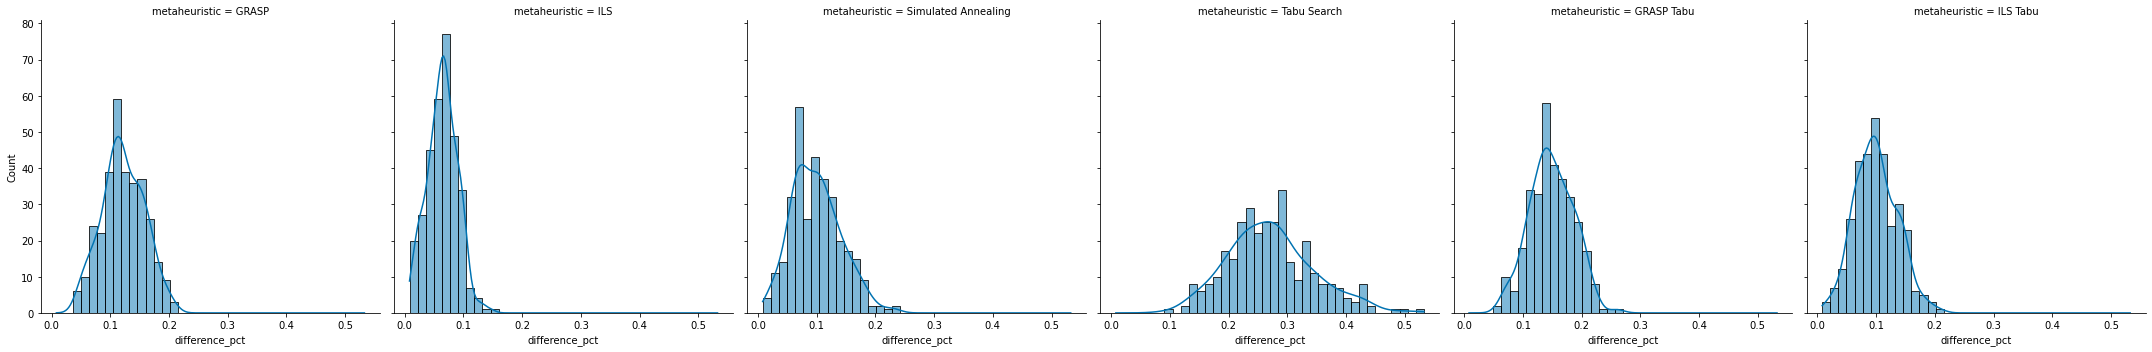

In [10]:
sns.displot(data=df, kde=True, x='difference_pct', col='metaheuristic')#, hue='alpha')#, multiple='stack')

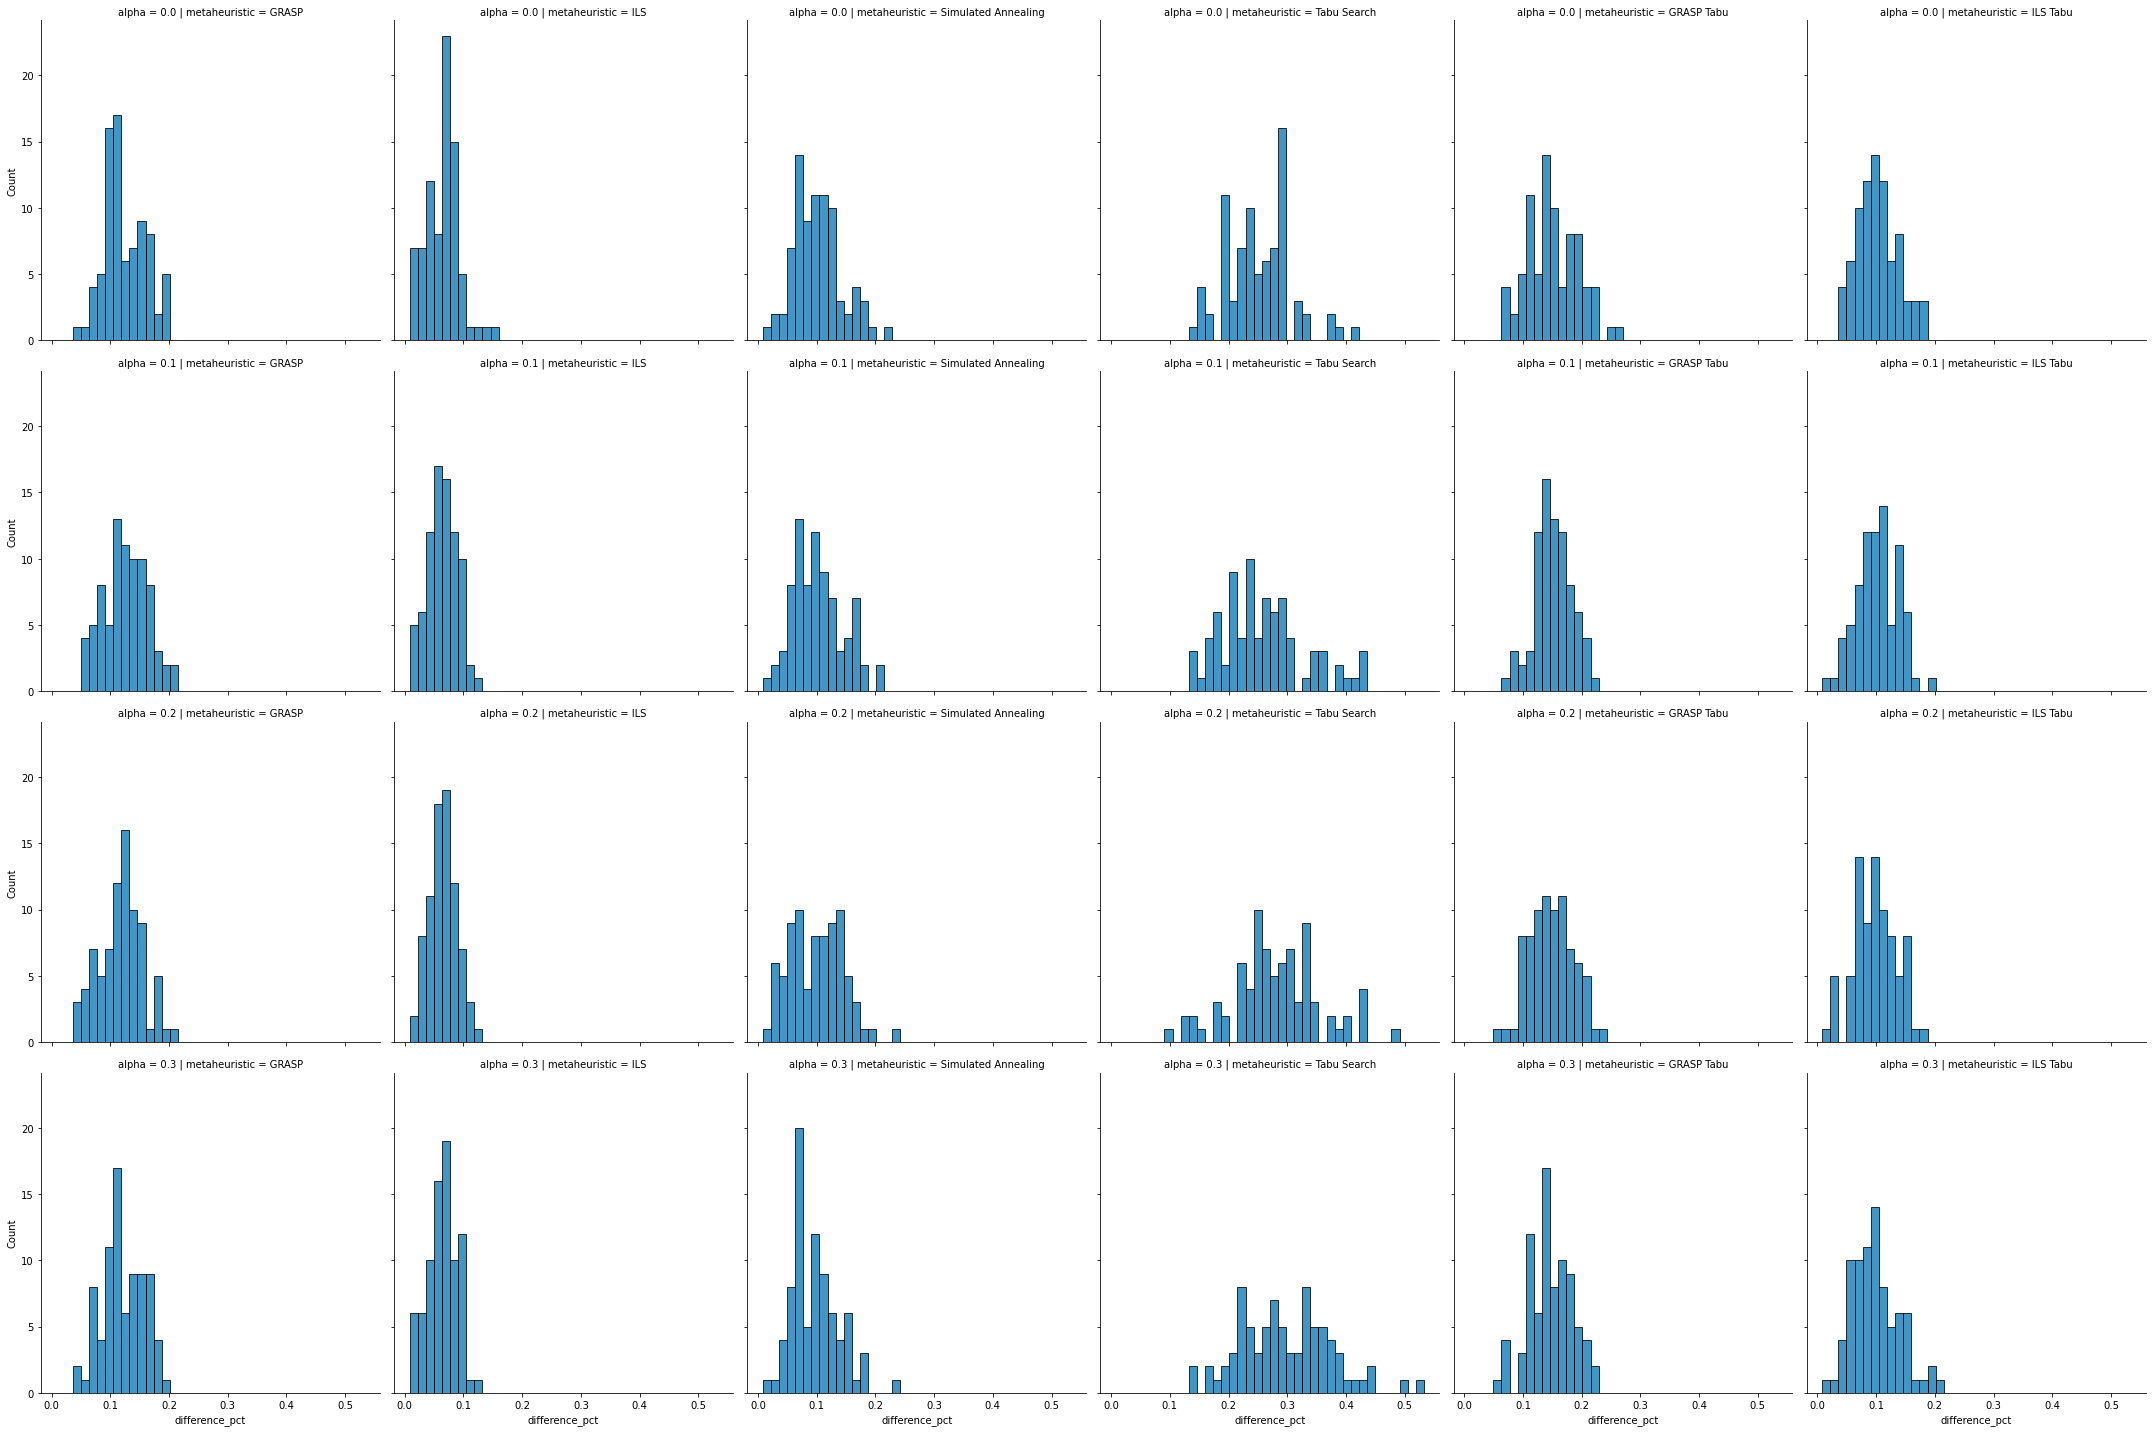

In [16]:
sns.displot(data=df, x='difference_pct', row='alpha', col='metaheuristic')

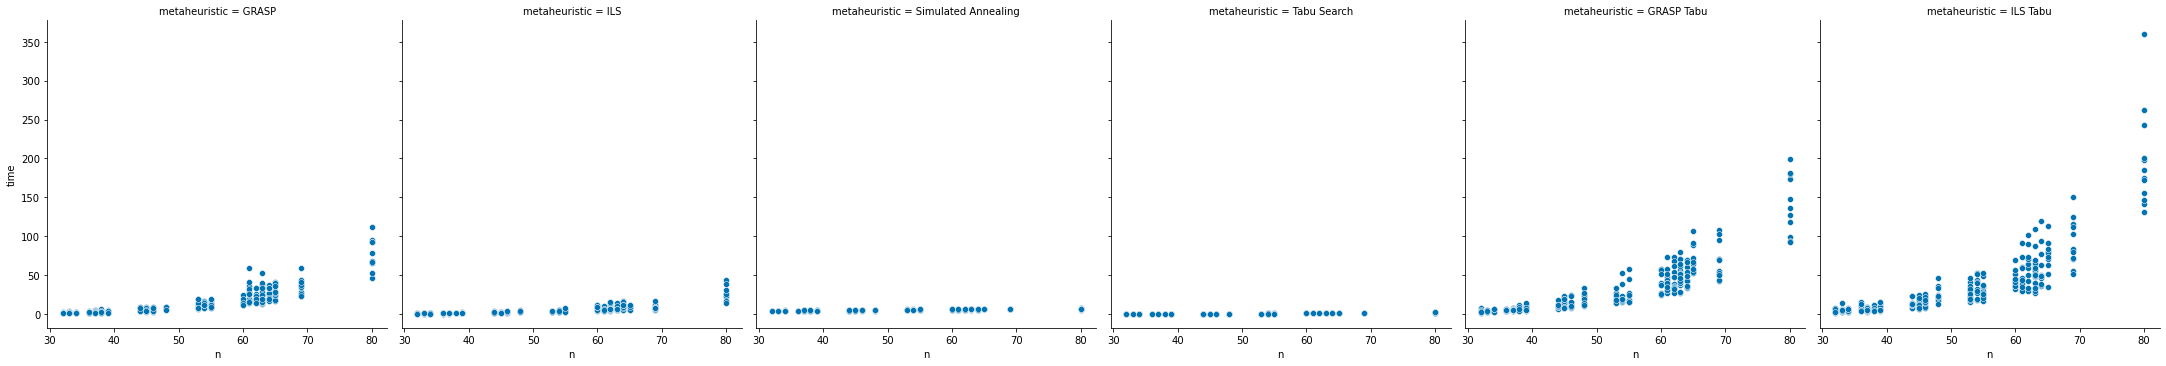

In [23]:
sns.relplot(data=df, x='n', y='time', col='metaheuristic')

## Consolidado

In [3]:
df = pd.read_csv('results/consolidated.tsv', sep='\t')
df.head()

,instance,alpha,metaheuristic,time,cost,optimum
0,A-n32-k5,0.0,GRASP,0.776041,815,784
1,A-n32-k5,0.0,GRASP Tabu,2.578128,861,784
2,A-n32-k5,0.0,ILS,0.375001,815,784
3,A-n32-k5,0.0,ILS Tabu,3.468750,844,784
4,A-n32-k5,0.0,Simulated Annealing,3.671872,872,784


In [16]:
df_costs = pd.pivot_table(df, index='instance', columns='metaheuristic', values='cost', aggfunc='min').join(df.groupby('instance')['optimum'].min()).reset_index()
df_costs.to_csv('results/costs.tsv', sep='\t', index=False)

In [17]:
df_costs = pd.pivot_table(df, index='instance', columns='metaheuristic', values='time', aggfunc='mean').reset_index()
df_costs.to_csv('results/times.tsv', sep='\t', index=False)